# 04. Pytorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets

## Domain libraries

Depending on what you're looking on, vision, text, audio, recommendation, you'll want to look each of the PyTorch domain libreries for existing data loading functions and customizable data loading functions

**Resources:**
* Book version of the course materials for 04 https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version fo notebook 04

## 0 Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: Pytorch 1.10.0 + is required for this course
torch.__version__

'2.5.1+cu124'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1 Get some data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do ths?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.



In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exst... skipping download")
else:
  print(f"{image_path} directory doesn't  exst... creating one")
  image_path.mkdir(parents=True,
                   exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak and sushi
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unziping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't  exst... creating one
Unziping pizza, steak and sushi data...


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data (data preparation and data exploration)

In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi' .
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train' .
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak' .
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi' .
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza' .
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test' .
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak' .
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi' .
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza' .


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some come to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working in images, let's open the image with Python's PIL
5. We'll then show the image and print the metadata

data/pizza_steak_sushi/train/sushi/2021381.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/2021381.jpg
Image class: sushi
Image height: 512
Image width: 512


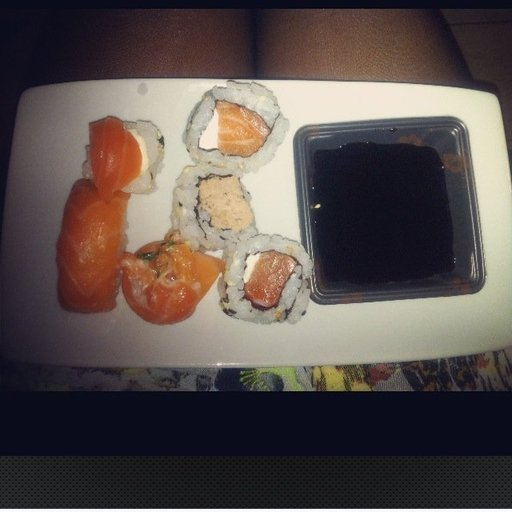

In [9]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list= list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

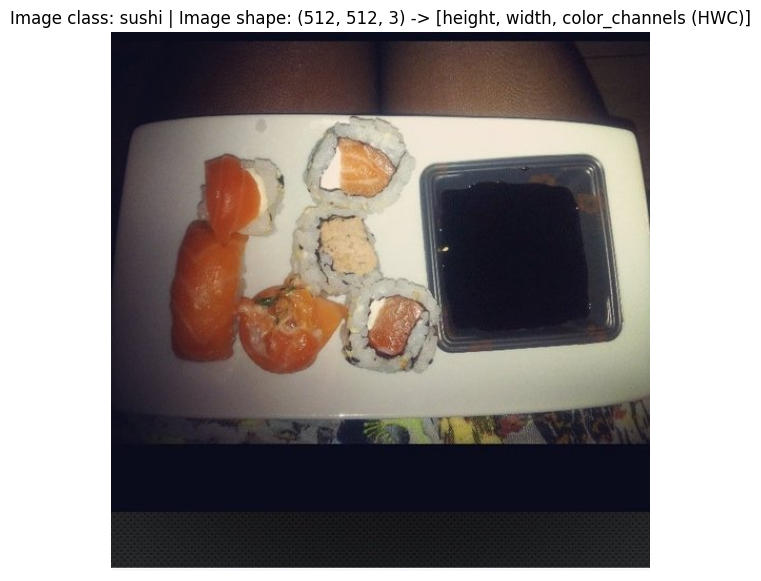

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels (HWC)]")
plt.axis(False)

## 3 Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensor (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `Dataloader`

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to used with a model/perform data augmentation

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64,64)),
  # Fllp the images randomly on the horizonatal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.0471, 0.0471, 0.0471,  ..., 0.0392, 0.0392, 0.0392],
         [0.1059, 0.1098, 0.1137,  ..., 0.0549, 0.0549, 0.0549],
         [0.1216, 0.1255, 0.1255,  ..., 0.0510, 0.0510, 0.0510],
         ...,
         [0.1412, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1412],
         [0.1451, 0.1412, 0.1412,  ..., 0.1412, 0.1412, 0.1451],
         [0.4078, 0.4078, 0.4039,  ..., 0.4039, 0.4078, 0.4078]],

        [[0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
         [0.0863, 0.0941, 0.0941,  ..., 0.0549, 0.0510, 0.0510],
         [0.0902, 0.0980, 0.0980,  ..., 0.0510, 0.0510, 0.0510],
         ...,
         [0.1451, 0.1451, 0.1451,  ..., 0.1451, 0.1451, 0.1451],
         [0.1490, 0.1451, 0.1451,  ..., 0.1451, 0.1490, 0.1490],
         [0.4118, 0.4118, 0.4078,  ..., 0.4078, 0.4118, 0.4118]],

        [[0.1059, 0.1059, 0.1059,  ..., 0.1059, 0.1059, 0.1059],
         [0.1255, 0.1294, 0.1333,  ..., 0.1098, 0.1059, 0.1059],
         [0.1294, 0.1294, 0.1294,  ..., 0.1098, 0.1137, 0.

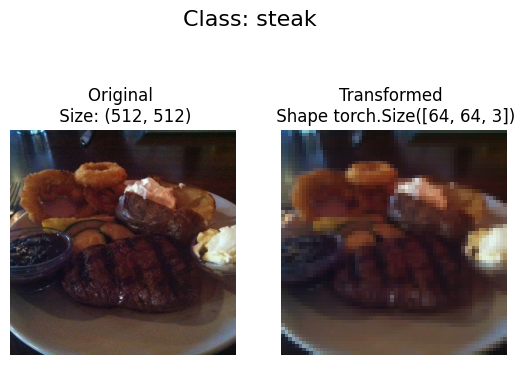

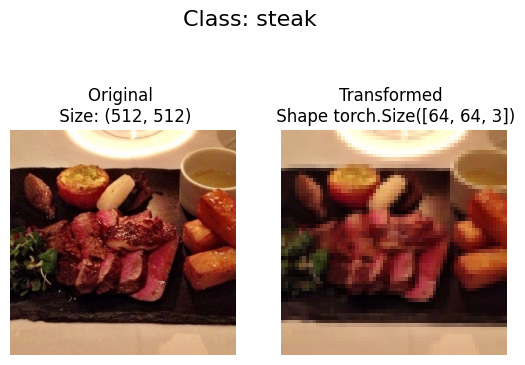

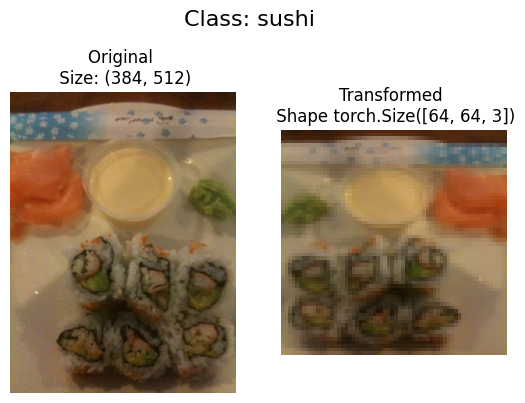

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis(False)

      # Transform and plot target iamge
      transformed_image = transform(f).permute(1, 2, 0) # note: we'll need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4 Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [15]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # a transform for the label/target


test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the lenghts of our dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.targets[0]

0

In [20]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

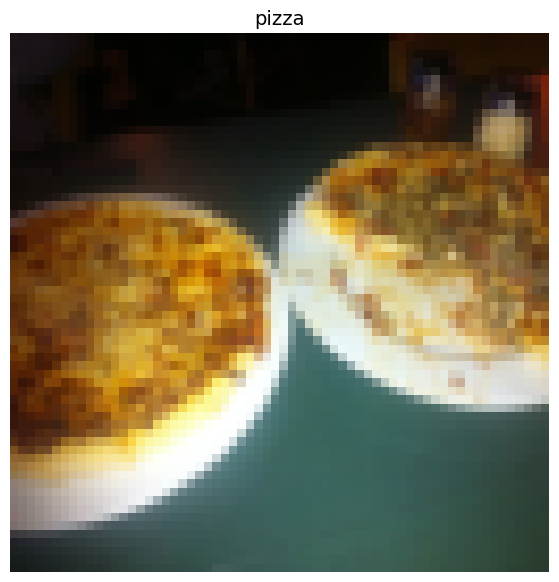

In [21]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoaders's`

A `DataLoader` is going to help us turn on `Dataset's` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time. In other case, we hardware gonna be out memory

In [22]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [23]:
# Well count the number of cpu's available
import os
os.cpu_count()

2

In [24]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [25]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-build `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean, that it'll work...
* Using a custon  `Dataset` often results in us writting more code, which could be prone to errors or performance issues

In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instace of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standar image classification format).
2. Raise and error if te class names aren't found (if this happend, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [31]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [38]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory.
  """

  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary of index labels (computers prefer number rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [39]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom dataset to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transformer if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mappeed to integer labels

## 6 Other forms of transforms (data augmentation)

Data augmentation is the process of artificial adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This pracice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [40]:
# Let's look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [42]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/3857508.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2163079.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3518960.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614189.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/214320.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/225990.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2979061.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/75537.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg')]

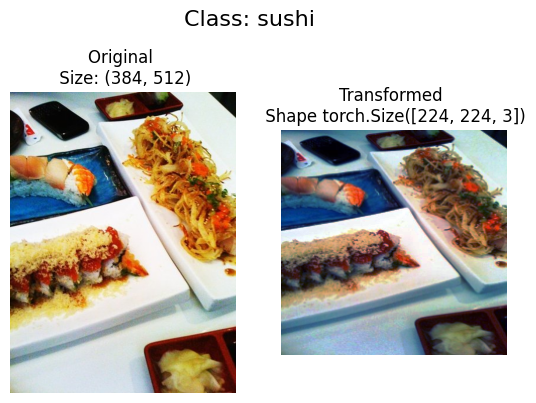

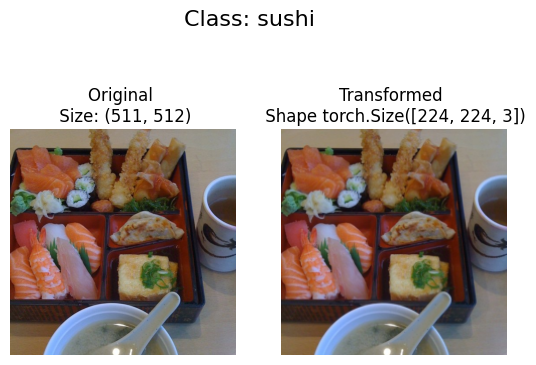

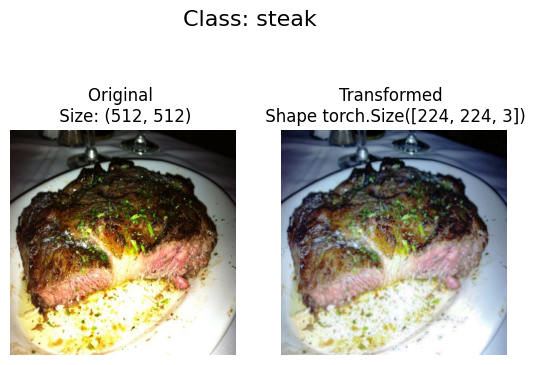

In [43]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)